Using device: cuda
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU
Epoch 1/12:
Train Loss: 0.2538, Train Acc: 92.21%
Valid Loss: 0.0526, Valid Acc: 98.58%
Epoch 2/12:
Train Loss: 0.0991, Train Acc: 97.07%
Valid Loss: 0.0422, Valid Acc: 98.80%
Epoch 3/12:
Train Loss: 0.0723, Train Acc: 97.83%
Valid Loss: 0.0375, Valid Acc: 98.94%
Epoch 4/12:
Train Loss: 0.0601, Train Acc: 98.18%
Valid Loss: 0.0359, Valid Acc: 99.14%
Epoch 5/12:
Train Loss: 0.0537, Train Acc: 98.39%
Valid Loss: 0.0377, Valid Acc: 99.04%
Epoch 6/12:
Train Loss: 0.0457, Train Acc: 98.61%
Valid Loss: 0.0345, Valid Acc: 99.00%
Epoch 7/12:
Train Loss: 0.0399, Train Acc: 98.72%
Valid Loss: 0.0309, Valid Acc: 99.20%
Epoch 8/12:
Train Loss: 0.0357, Train Acc: 98.90%
Valid Loss: 0.0333, Valid Acc: 99.22%
Epoch 9/12:
Train Loss: 0.0345, Train Acc: 98.84%
Valid Loss: 0.0303, Valid Acc: 99.22%
Epoch 10/12:
Train Loss: 0.0289, Train Acc: 99.04%
Valid Loss: 0.0357, Valid Acc: 99.28%
Epoch 11/12:
Train Loss: 0.0276, Train Acc: 99.12%
Vali

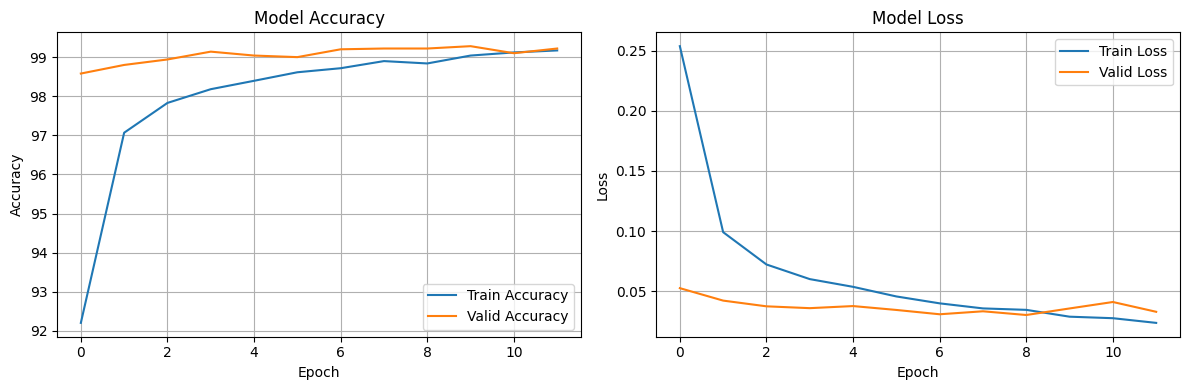

Model zapisany jako 'mnist_model.pth'
Zapisano X_test i y_test


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset_full = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_indices = list(range(0, len(trainset_full) - 5000))
valid_indices = list(range(len(trainset_full) - 5000, len(trainset_full)))
trainset = Subset(trainset_full, train_indices)
validset = Subset(trainset_full, valid_indices)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
validloader = DataLoader(validset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, trainloader, validloader, epochs=10):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        valid_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        valid_loss = valid_loss / len(validloader)
        valid_acc = 100 * correct / total
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, trainloader, validloader, epochs=12)

model.eval()
test_loss, correct, total = 0.0, 0, 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(testloader)
test_acc = 100 * correct / total
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

torch.save(model.state_dict(), "mnist_model.pth")
print("Model zapisany jako 'mnist_model.pth'")
np.save("X_test.npy", testset.data.numpy())
np.save("y_test.npy", testset.targets.numpy())
print("Zapisano X_test i y_test")

Model załadowany z 'mnist_model.pth'
Załadowano X_test i y_test


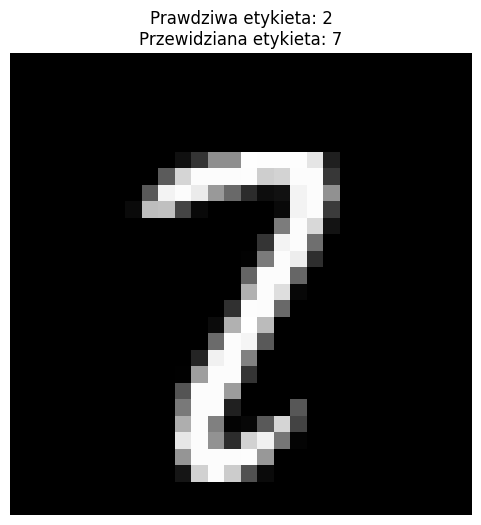

In [ ]:
import random
model = CNN().to(device)
model.load_state_dict(torch.load("mnist_model.pth"))
model.eval()
print("Model załadowany z 'mnist_model.pth'")

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
print("Załadowano X_test i y_test")

def classify_and_show_image(model, X_test, y_test, index):
    if index < 0 or index >= len(X_test):
        print(f"Indeks {index} jest poza zakresem. Wybierz indeks od 0 do {len(X_test)-1}")
        return

    image = X_test[index]
    true_label = y_test[index]
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0
    image_tensor = (image_tensor - 0.5) / 0.5
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        output = model(image_tensor)
        predicted_label = torch.argmax(output, dim=1).item()

    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(f"Prawdziwa etykieta: {true_label}\nPrzewidziana etykieta: {predicted_label}")
    plt.axis('off')
    plt.show()

index_to_predict = random.randint(0, 9999)
classify_and_show_image(model, X_test, y_test, index_to_predict)

Model załadowany z 'mnist_model.pth'
Załadowano X_test i y_test


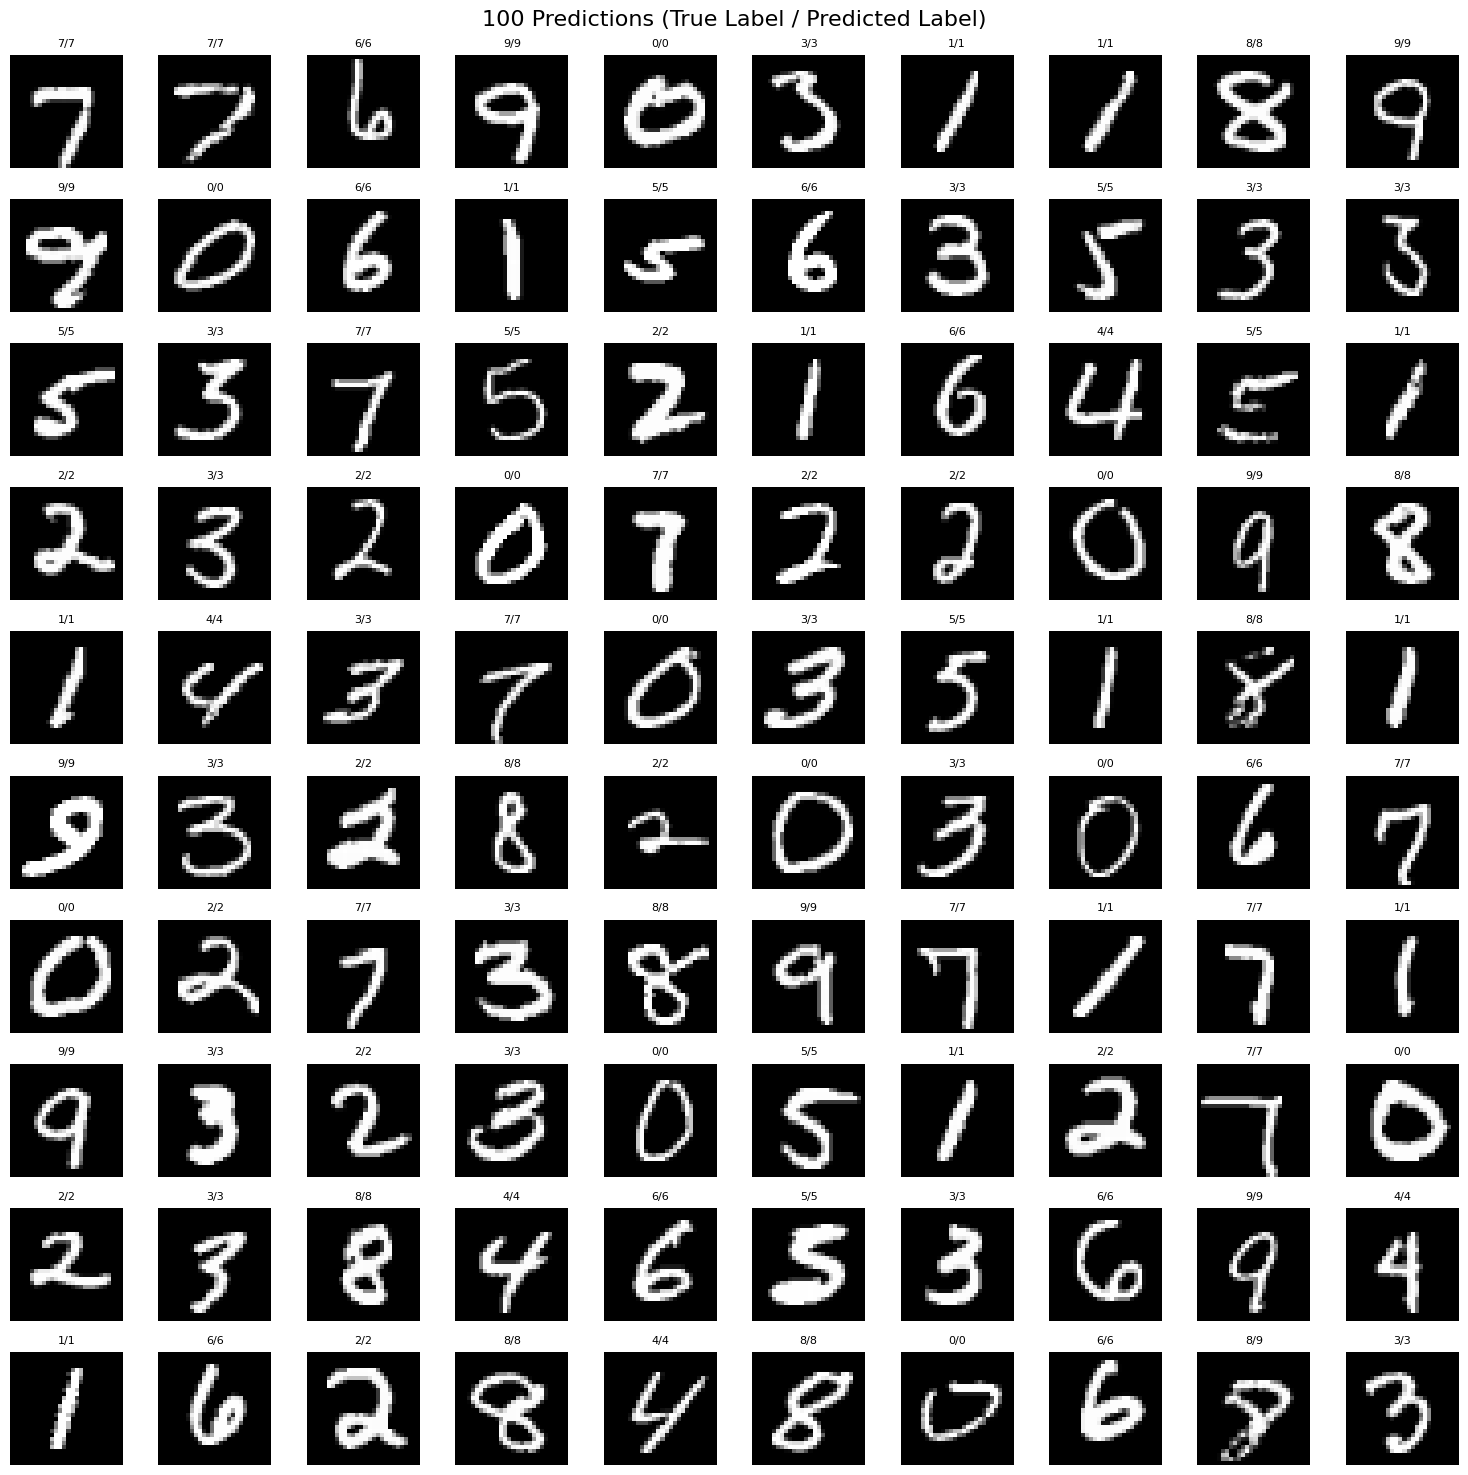

Zapisano siatkę predykcji jako '100_predictions_grid.png'


<Figure size 640x480 with 0 Axes>

In [ ]:
model = CNN().to(device)
model.load_state_dict(torch.load("mnist_model.pth"))
model.eval()
print("Model załadowany z 'mnist_model.pth'")

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
print("Załadowano X_test i y_test")

#np.random.seed(42) # Tutaj widać jak bardzo ludzie nie umią pisać
indices = np.random.choice(len(X_test), 100, replace=False)

images = torch.tensor(X_test[indices], dtype=torch.float32).unsqueeze(1) / 255.0
images = (images - 0.5) / 0.5
images = images.to(device)
true_labels = y_test[indices]

with torch.no_grad():
    outputs = model(images)
    predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
fig.suptitle("100 Predictions (True Label / Predicted Label)", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[indices[i]], cmap='gray')
    ax.axis('off')
    ax.set_title(f"{true_labels[i]}/{predicted_labels[i]}", fontsize=8)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

plt.savefig("100_predictions_grid.png")
print("Zapisano siatkę predykcji jako '100_predictions_grid.png'")